<a href="https://colab.research.google.com/github/mahal7446/Kisan_Sathi/blob/main/Model_Training2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

BASE_DIR = "/content/drive/MyDrive/Kisan_Sathi_Split"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print("Train path exists:", os.path.exists(TRAIN_DIR))
print("Val path exists:", os.path.exists(VAL_DIR))
print("Test path exists:", os.path.exists(TEST_DIR))


Train path exists: True
Val path exists: True
Test path exists: True


In [3]:
classes = sorted(os.listdir(TRAIN_DIR))
num_classes = len(classes)

print("Classes:", classes)
print("Number of classes:", num_classes)


Classes: ['Blackgram_Anthracnose', 'Blackgram_Healthy', 'Blackgram_LeafCrinckle', 'Blackgram_PowderyMildew', 'Blackgram_YellowMosaic', 'Corn_Blight', 'Corn_CommonRust', 'Corn_GrayLeafSpot', 'Corn_Healthy']
Number of classes: 9


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 1403 images belonging to 9 classes.


In [6]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 299 images belonging to 9 classes.
Found 305 images belonging to 9 classes.


In [7]:
print("Class indices:")
print(train_generator.class_indices)


Class indices:
{'Blackgram_Anthracnose': 0, 'Blackgram_Healthy': 1, 'Blackgram_LeafCrinckle': 2, 'Blackgram_PowderyMildew': 3, 'Blackgram_YellowMosaic': 4, 'Corn_Blight': 5, 'Corn_CommonRust': 6, 'Corn_GrayLeafSpot': 7, 'Corn_Healthy': 8}


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model


In [9]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [14]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_model_stage1.h5',
        monitor='val_loss',
        save_best_only=True
    )
]


In [15]:
EPOCHS = 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1553 - loss: 2.5369 

44/44 ━━━━━━━━━━━━━━━━━━━━ 586s 13s/step - accuracy: 0.1558 - loss: 2.5348 - val_accuracy: 0.2542 - val_loss: 2.0139 - learning_rate: 1.0000e-04
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2584 - loss: 2.0992

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2586 - loss: 2.0983 - val_accuracy: 0.3980 - val_loss: 1.6809 - learning_rate: 1.0000e-04
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3570 - loss: 1.8029

44/44 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.3576 - loss: 1.8017 - val_accuracy: 0.5050 - val_loss: 1.4332 - learning_rate: 1.0000e-04
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4546 - loss: 1.5441

44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4542 - loss: 1.5438 - val_accuracy: 0.5753 - val_loss: 1.2622 - learning_rate: 1.0000e-04
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5440 - loss: 1.3385

44/44 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5439 - loss: 1.3387 - val_accuracy: 0.6221 - val_loss: 1.1164 - learning_rate: 1.0000e-04
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5443 - loss: 1.2610

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5447 - loss: 1.2603 - val_accuracy: 0.6522 - val_loss: 1.0113 - learning_rate: 1.0000e-04
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6139 - loss: 1.1236

44/44 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6140 - loss: 1.1237 - val_accuracy: 0.6722 - val_loss: 0.9226 - learning_rate: 1.0000e-04
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6467 - loss: 1.0234

44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6465 - loss: 1.0238 - val_accuracy: 0.7258 - val_loss: 0.8451 - learning_rate: 1.0000e-04
Epoch 9/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6521 - loss: 0.9928

44/44 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6526 - loss: 0.9918 - val_accuracy: 0.7458 - val_loss: 0.7842 - learning_rate: 1.0000e-04
Epoch 10/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7031 - loss: 0.8685

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7030 - loss: 0.8686 - val_accuracy: 0.7625 - val_loss: 0.7304 - learning_rate: 1.0000e-04
Epoch 11/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7234 - loss: 0.8368

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7232 - loss: 0.8368 - val_accuracy: 0.7826 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 12/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7220 - loss: 0.8314

44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7224 - loss: 0.8305 - val_accuracy: 0.8060 - val_loss: 0.6449 - learning_rate: 1.0000e-04
Epoch 13/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7576 - loss: 0.7609

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7575 - loss: 0.7610 - val_accuracy: 0.8094 - val_loss: 0.6132 - learning_rate: 1.0000e-04
Epoch 14/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7342 - loss: 0.7507

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7345 - loss: 0.7500 - val_accuracy: 0.8261 - val_loss: 0.5889 - learning_rate: 1.0000e-04
Epoch 15/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7709 - loss: 0.6652

44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7711 - loss: 0.6653 - val_accuracy: 0.8294 - val_loss: 0.5602 - learning_rate: 1.0000e-04


In [16]:
# Unfreeze the top layers of MobileNetV2
base_model.trainable = True

# Freeze all layers except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
FINE_TUNE_EPOCHS = 10

history_fine = model.fit(
    train_generator,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6563 - loss: 1.0188

44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6570 - loss: 1.0170 - val_accuracy: 0.8595 - val_loss: 0.5029 - learning_rate: 1.0000e-05
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7683 - loss: 0.7380

44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7685 - loss: 0.7374 - val_accuracy: 0.8595 - val_loss: 0.4718 - learning_rate: 1.0000e-05
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7711 - loss: 0.6792

44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7716 - loss: 0.6781 - val_accuracy: 0.8562 - val_loss: 0.4510 - learning_rate: 1.0000e-05
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8293 - loss: 0.5429

44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8292 - loss: 0.5426 - val_accuracy: 0.8562 - val_loss: 0.4272 - learning_rate: 1.0000e-05
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8508 - loss: 0.4913

44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8509 - loss: 0.4912 - val_accuracy: 0.8662 - val_loss: 0.4031 - learning_rate: 1.0000e-05
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8668 - loss: 0.4360

44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8667 - loss: 0.4362 - val_accuracy: 0.8662 - val_loss: 0.3848 - learning_rate: 1.0000e-05
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8877 - loss: 0.3690

44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8875 - loss: 0.3695 - val_accuracy: 0.8729 - val_loss: 0.3633 - learning_rate: 1.0000e-05
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9041 - loss: 0.3580

44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9037 - loss: 0.3584 - val_accuracy: 0.8763 - val_loss: 0.3470 - learning_rate: 1.0000e-05
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8970 - loss: 0.3417

44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8970 - loss: 0.3415 - val_accuracy: 0.8829 - val_loss: 0.3369 - learning_rate: 1.0000e-05
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8884 - loss: 0.3240

44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8884 - loss: 0.3240 - val_accuracy: 0.8930 - val_loss: 0.3230 - learning_rate: 1.0000e-05


In [20]:
from tensorflow.keras.models import load_model

model = load_model('best_model_stage1.h5')


In [21]:
import numpy as np

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 9s/step


In [22]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
))


                         precision    recall  f1-score   support

  Blackgram_Anthracnose       0.94      0.91      0.93        35
      Blackgram_Healthy       0.79      1.00      0.88        34
 Blackgram_LeafCrinckle       0.95      0.83      0.88        23
Blackgram_PowderyMildew       0.79      0.81      0.80        27
 Blackgram_YellowMosaic       0.97      0.82      0.89        34
            Corn_Blight       0.88      0.58      0.70        38
        Corn_CommonRust       0.90      0.95      0.92        38
      Corn_GrayLeafSpot       0.70      0.79      0.74        38
           Corn_Healthy       0.88      1.00      0.94        38

               accuracy                           0.86       305
              macro avg       0.87      0.85      0.85       305
           weighted avg       0.86      0.86      0.85       305



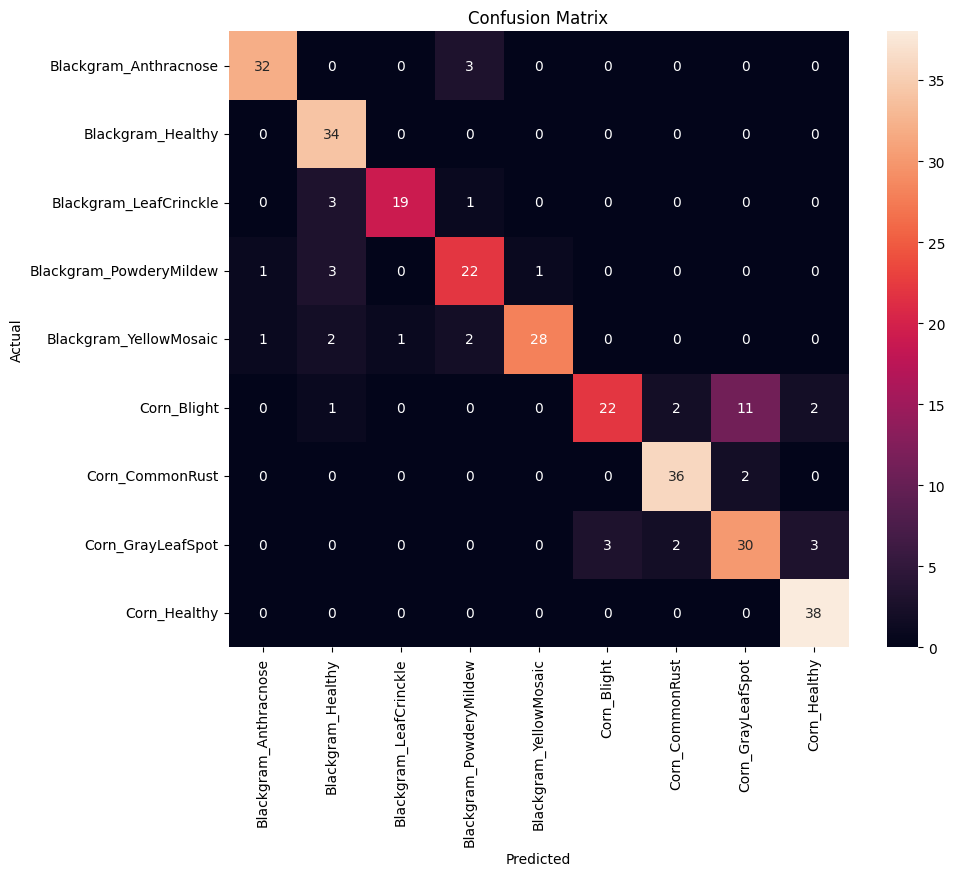

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [24]:
model.save("KisanSathi_Disease_Model.h5")
print("Model saved successfully!")


Model saved successfully!


In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load model
model = load_model("KisanSathi_Disease_Model.h5")

# Class labels (same order as training)
class_names = list(train_generator.class_indices.keys())

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")


In [30]:
predict_image("/content/drive/MyDrive/Kisan_Sathi_Split/test/Corn_CommonRust/Corn_Common_Rust (474).JPG")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Disease: Corn_CommonRust
Confidence: 98.46%
